In [1]:
#Install some missing libraries
!pip install geopandas
!pip install descartes
!pip install gpdvega

    100% |████████████████████████████████| 901kB 17.0MB/s 
    100% |████████████████████████████████| 1.5MB 14.1MB/s 
    100% |████████████████████████████████| 17.9MB 2.5MB/s 
  Stored in directory: /home/jupyterlab/.cache/pip/wheels/db/bf/bc/06a3e1bfe0ab27d2e720ceb3cff3159398d92644c0cec2c125
Successfully built munch


In [2]:
#imports
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', -1)

import folium
import altair as alt
import geopandas as gpd
import gpdvega 
from fiona.crs import from_epsg
import time
from sklearn.cluster import KMeans

# Clustering the Neighbourhoods of Toronto

#### Approach:
- find some deomography data and try to cluster based on that
- complement with Foursquare data and see how the results changed

### Read the geographical data and make a quick visualization

Calculate the area in suqare km of each eighbourhood as it could be useful further on (especially when combining it with demographical information)

['AREA_CODE', 'neighbourhood', 'geometry', 'area_km2']


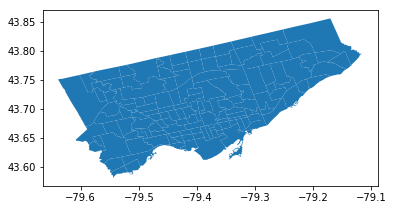

In [24]:
shape_df = gpd.read_file('./data/toronto_neighbourhoods_shape/NEIGHBOURHOODS_UTM6.shp')

#Extract the area in square km
shape_df['area_km2'] = shape_df['geometry'].area/ 10**6
shape_df['AREA_NAME'] = shape_df['AREA_NAME'].apply(lambda x: x.split(' (')[0])

#Transform the coordinates in latitude and longitude and plot
shape_df = shape_df.to_crs({'init': 'epsg:4326'})
shape_df.rename(columns = {'AREA_NAME':'neighbourhood'}, inplace =True)

print(shape_df.columns.tolist())

shape_df.plot()

### Get demographics data

Download the [2016 neighbourhoods census result](https://www.toronto.ca/city-government/data-research-maps/open-data/open-data-catalogue/locations-and-mapping/#8c732154-5012-9afe-d0cd-ba3ffc813d5a)

Do a brief inspection to see what could be relevant criteria for clustering the neighbourhoods.

In [ ]:
!wget --directory-prefix=./data 'https://www.toronto.ca/ext/open_data/catalog/data_set_files/2016_neighbourhood_profiles.csv'

In [5]:
demo = pd.read_csv('./data/2016_neighbourhood_profiles.csv', encoding='Latin-1', error_bad_lines=False)
demo.head(1)

,Category,Topic,Data Source,Characteristic,City of Toronto,Agincourt North,Agincourt South-Malvern West,Alderwood,Annex,Banbury-Don Mills,Bathurst Manor,Bay Street Corridor,Bayview Village,Bayview Woods-Steeles,Bedford Park-Nortown,Beechborough-Greenbrook,Bendale,Birchcliffe-Cliffside,Black Creek,Blake-Jones,Briar Hill-Belgravia,Bridle Path-Sunnybrook-York Mills,Broadview North,Brookhaven-Amesbury,Cabbagetown-South St. James Town,Caledonia-Fairbank,Casa Loma,Centennial Scarborough,Church-Yonge Corridor,Clairlea-Birchmount,Clanton Park,Cliffcrest,Corso Italia-Davenport,Danforth,Danforth East York,Don Valley Village,Dorset Park,Dovercourt-Wallace Emerson-Junction,Downsview-Roding-CFB,Dufferin Grove,East End-Danforth,Edenbridge-Humber Valley,Eglinton East,Elms-Old Rexdale,Englemount-Lawrence,Eringate-Centennial-West Deane,Etobicoke West Mall,Flemingdon Park,Forest Hill North,Forest Hill South,Glenfield-Jane Heights,Greenwood-Coxwell,Guildwood,Henry Farm,High Park North,High Park-Swansea,Highland Creek,Hillcrest Village,Humber Heights-Westmount,Humber Summit,Humbermede,Humewood-Cedarvale,Ionview,Islington-City Centre West,Junction Area,Keelesdale-Eglinton West,Kennedy Park,Kensington-Chinatown,Kingsview Village-The Westway,Kingsway South,Lambton Baby Point,L'Amoreaux,Lansing-Westgate,Lawrence Park North,Lawrence Park South,Leaside-Bennington,Little Portugal,Long Branch,Malvern,Maple Leaf,Markland Wood,Milliken,Mimico (includes Humber Bay Shores),Morningside,Moss Park,Mount Dennis,Mount Olive-Silverstone-Jamestown,Mount Pleasant East,Mount Pleasant West,New Toronto,Newtonbrook East,Newtonbrook West,Niagara,North Riverdale,North St. James Town,Oakridge,Oakwood Village,O'Connor-Parkview,Old East York,Palmerston-Little Italy,Parkwoods-Donalda,Pelmo Park-Humberlea,Playter Estates-Danforth,Pleasant View,Princess-Rosethorn,Regent Park,Rexdale-Kipling,Rockcliffe-Smythe,Roncesvalles,Rosedale-Moore Park,Rouge,Runnymede-Bloor West Village,Rustic,Scarborough Village,South Parkdale,South Riverdale,St.Andrew-Windfields,Steeles,Stonegate-Queensway,Tam O'Shanter-Sullivan,Taylor-Massey,The Beaches,Thistletown-Beaumond Heights,Thorncliffe Park,Trinity-Bellwoods,University,Victoria Village,Waterfront Communities-The Island,West Hill,West Humber-Clairville,Westminster-Branson,Weston,Weston-Pelham Park,Wexford/Maryvale,Willowdale East,Willowdale West,Willowridge-Martingrove-Richview,Woburn,Woodbine Corridor,Woodbine-Lumsden,Wychwood,Yonge-Eglinton,Yonge-St.Clair,York University Heights,Yorkdale-Glen Park
0,Neighbourhood Information,Neighbourhood Information,City of Toronto,Neighbourhood Number,NaN,129,128,20,95,42,34,76,52,49,39,112,127,122,24,69,108,41,57,30,71,109,96,133,75,120,33,123,92,66,59,47,126,93,26,83,62,9,138,5,32,11,13,44,102,101,25,65,140,53,88,87,134,48,8,21,22,106,125,14,90,110,124,78,6,15,114,117,38,105,103,56,84,19,132,29,12,130,17,135,73,115,2,99,104,18,50,36,82,68,74,121,107,54,58,80,45,23,67,46,10,72,4,111,86,98,131,89,28,139,85,70,40,116,16,118,61,63,3,55,81,79,43,77,136,1,35,113,91,119,51,37,7,137,64,60,94,100,97,27,31


##### Get the total population by neighbourhood

In [6]:
pop = demo[(demo.Topic=='Population and dwellings')&(demo.Characteristic=='Population, 2016')]
pop[pop.columns[4:].tolist()] = pop[pop.columns[4:].tolist()].apply(lambda x: x.str.replace(',','')).astype(int)
pop.head()

/home/jupyterlab/conda/lib/python3.6/site-packages/pandas/core/frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


,Category,Topic,Data Source,Characteristic,City of Toronto,Agincourt North,Agincourt South-Malvern West,Alderwood,Annex,Banbury-Don Mills,Bathurst Manor,Bay Street Corridor,Bayview Village,Bayview Woods-Steeles,Bedford Park-Nortown,Beechborough-Greenbrook,Bendale,Birchcliffe-Cliffside,Black Creek,Blake-Jones,Briar Hill-Belgravia,Bridle Path-Sunnybrook-York Mills,Broadview North,Brookhaven-Amesbury,Cabbagetown-South St. James Town,Caledonia-Fairbank,Casa Loma,Centennial Scarborough,Church-Yonge Corridor,Clairlea-Birchmount,Clanton Park,Cliffcrest,Corso Italia-Davenport,Danforth,Danforth East York,Don Valley Village,Dorset Park,Dovercourt-Wallace Emerson-Junction,Downsview-Roding-CFB,Dufferin Grove,East End-Danforth,Edenbridge-Humber Valley,Eglinton East,Elms-Old Rexdale,Englemount-Lawrence,Eringate-Centennial-West Deane,Etobicoke West Mall,Flemingdon Park,Forest Hill North,Forest Hill South,Glenfield-Jane Heights,Greenwood-Coxwell,Guildwood,Henry Farm,High Park North,High Park-Swansea,Highland Creek,Hillcrest Village,Humber Heights-Westmount,Humber Summit,Humbermede,Humewood-Cedarvale,Ionview,Islington-City Centre West,Junction Area,Keelesdale-Eglinton West,Kennedy Park,Kensington-Chinatown,Kingsview Village-The Westway,Kingsway South,Lambton Baby Point,L'Amoreaux,Lansing-Westgate,Lawrence Park North,Lawrence Park South,Leaside-Bennington,Little Portugal,Long Branch,Malvern,Maple Leaf,Markland Wood,Milliken,Mimico (includes Humber Bay Shores),Morningside,Moss Park,Mount Dennis,Mount Olive-Silverstone-Jamestown,Mount Pleasant East,Mount Pleasant West,New Toronto,Newtonbrook East,Newtonbrook West,Niagara,North Riverdale,North St. James Town,Oakridge,Oakwood Village,O'Connor-Parkview,Old East York,Palmerston-Little Italy,Parkwoods-Donalda,Pelmo Park-Humberlea,Playter Estates-Danforth,Pleasant View,Princess-Rosethorn,Regent Park,Rexdale-Kipling,Rockcliffe-Smythe,Roncesvalles,Rosedale-Moore Park,Rouge,Runnymede-Bloor West Village,Rustic,Scarborough Village,South Parkdale,South Riverdale,St.Andrew-Windfields,Steeles,Stonegate-Queensway,Tam O'Shanter-Sullivan,Taylor-Massey,The Beaches,Thistletown-Beaumond Heights,Thorncliffe Park,Trinity-Bellwoods,University,Victoria Village,Waterfront Communities-The Island,West Hill,West Humber-Clairville,Westminster-Branson,Weston,Weston-Pelham Park,Wexford/Maryvale,Willowdale East,Willowdale West,Willowridge-Martingrove-Richview,Woburn,Woodbine Corridor,Woodbine-Lumsden,Wychwood,Yonge-Eglinton,Yonge-St.Clair,York University Heights,Yorkdale-Glen Park
2,Population,Population and dwellings,Census Profile 98-316-X2016001,"Population, 2016",2731571,29113,23757,12054,30526,27695,15873,25797,21396,13154,23236,6577,29960,22291,21737,7727,14257,9266,11499,17757,11669,9955,10968,13362,31340,26984,16472,15935,14133,9666,17180,27051,25003,36625,35052,11785,21381,15535,22776,9456,22372,18588,11848,21933,12806,10732,30491,14417,9917,15723,22162,23925,12494,16934,10948,12416,15545,14365,13641,43965,14366,11058,17123,17945,22000,9271,7985,43993,16164,14607,15179,16828,15559,10084,43794,10111,10554,26572,33964,17455,20506,13593,32954,16775,29658,11463,16097,23831,31180,11916,18615,13845,21210,18675,9233,13826,34805,10722,7804,15818,11051,10803,10529,22246,14974,20923,46496,10070,9941,16724,21849,27876,17812,24623,25051,27446,15683,21567,10360,21108,16556,7607,17510,65913,27392,33312,26274,17992,11098,27917,50434,16936,22156,53485,12541,7865,14349,11817,12528,27593,14804


##### Get the average tax after income per household

In [7]:
txt='Average after-tax income of households in 2015 ($)'
income = demo[demo['Characteristic'].str.contains(txt, regex=False)]
income[income.columns[4:].tolist()] = income[income.columns[4:].tolist()].apply(lambda x: x.str.replace(',','')).astype(int)
income.head()

,Category,Topic,Data Source,Characteristic,City of Toronto,Agincourt North,Agincourt South-Malvern West,Alderwood,Annex,Banbury-Don Mills,Bathurst Manor,Bay Street Corridor,Bayview Village,Bayview Woods-Steeles,Bedford Park-Nortown,Beechborough-Greenbrook,Bendale,Birchcliffe-Cliffside,Black Creek,Blake-Jones,Briar Hill-Belgravia,Bridle Path-Sunnybrook-York Mills,Broadview North,Brookhaven-Amesbury,Cabbagetown-South St. James Town,Caledonia-Fairbank,Casa Loma,Centennial Scarborough,Church-Yonge Corridor,Clairlea-Birchmount,Clanton Park,Cliffcrest,Corso Italia-Davenport,Danforth,Danforth East York,Don Valley Village,Dorset Park,Dovercourt-Wallace Emerson-Junction,Downsview-Roding-CFB,Dufferin Grove,East End-Danforth,Edenbridge-Humber Valley,Eglinton East,Elms-Old Rexdale,Englemount-Lawrence,Eringate-Centennial-West Deane,Etobicoke West Mall,Flemingdon Park,Forest Hill North,Forest Hill South,Glenfield-Jane Heights,Greenwood-Coxwell,Guildwood,Henry Farm,High Park North,High Park-Swansea,Highland Creek,Hillcrest Village,Humber Heights-Westmount,Humber Summit,Humbermede,Humewood-Cedarvale,Ionview,Islington-City Centre West,Junction Area,Keelesdale-Eglinton West,Kennedy Park,Kensington-Chinatown,Kingsview Village-The Westway,Kingsway South,Lambton Baby Point,L'Amoreaux,Lansing-Westgate,Lawrence Park North,Lawrence Park South,Leaside-Bennington,Little Portugal,Long Branch,Malvern,Maple Leaf,Markland Wood,Milliken,Mimico (includes Humber Bay Shores),Morningside,Moss Park,Mount Dennis,Mount Olive-Silverstone-Jamestown,Mount Pleasant East,Mount Pleasant West,New Toronto,Newtonbrook East,Newtonbrook West,Niagara,North Riverdale,North St. James Town,Oakridge,Oakwood Village,O'Connor-Parkview,Old East York,Palmerston-Little Italy,Parkwoods-Donalda,Pelmo Park-Humberlea,Playter Estates-Danforth,Pleasant View,Princess-Rosethorn,Regent Park,Rexdale-Kipling,Rockcliffe-Smythe,Roncesvalles,Rosedale-Moore Park,Rouge,Runnymede-Bloor West Village,Rustic,Scarborough Village,South Parkdale,South Riverdale,St.Andrew-Windfields,Steeles,Stonegate-Queensway,Tam O'Shanter-Sullivan,Taylor-Massey,The Beaches,Thistletown-Beaumond Heights,Thorncliffe Park,Trinity-Bellwoods,University,Victoria Village,Waterfront Communities-The Island,West Hill,West Humber-Clairville,Westminster-Branson,Weston,Weston-Pelham Park,Wexford/Maryvale,Willowdale East,Willowdale West,Willowridge-Martingrove-Richview,Woburn,Woodbine Corridor,Woodbine-Lumsden,Wychwood,Yonge-Eglinton,Yonge-St.Clair,York University Heights,Yorkdale-Glen Park
1026,Income,Income of households in 2015,Census Profile 98-316-X2016001,Average after-tax income of households in 2015 ($),81495,427037,278390,168602,792507,493486,251583,352218,354894,253036,720203,109880,326482,369161,261560,154132,190243,1392010,126349,176688,301145,132879,545338,215135,443734,350777,168893,248846,304000,260052,334260,414411,251476,594477,562794,128586,304010,441052,343031,123119,293189,352269,132460,261233,258469,784645,410012,216423,177062,202357,496958,483620,196620,298716,238655,202677,184459,289910,169046,854623,310473,184802,229390,222404,272950,900624,214945,529383,356122,470908,1216585,841619,202912,137480,533202,144062,195412,525507,583422,272837,170813,164344,360648,348357,443047,188819,335768,260415,369683,318764,144164,134303,267062,354525,257522,347339,623453,154568,194189,219209,538736,103250,134305,295358,377518,1413132,729154,223885,113995,185967,258500,662651,649291,363045,516575,475647,102259,659192,140050,195114,333954,197072,171271,662333,316750,426156,332776,171044,127491,336503,572155,272986,412302,629030,240272,147462,239484,222648,541217,302358,213860


##### Get the total number of people with higher education

In [8]:
txt="Bachelor's degree"
education = demo[demo['Characteristic'].str.contains(txt, regex=False)]
education[education.columns[4:].tolist()] = education[education.columns[4:].tolist()].apply(pd.to_numeric)
education = education.groupby(by=education.columns[:4].tolist()).agg('mean')
education.reset_index(inplace=True)
education.head()

,Category,Topic,Data Source,Characteristic,City of Toronto,Agincourt North,Agincourt South-Malvern West,Alderwood,Annex,Banbury-Don Mills,Bathurst Manor,Bay Street Corridor,Bayview Village,Bayview Woods-Steeles,Bedford Park-Nortown,Beechborough-Greenbrook,Bendale,Birchcliffe-Cliffside,Black Creek,Blake-Jones,Briar Hill-Belgravia,Bridle Path-Sunnybrook-York Mills,Broadview North,Brookhaven-Amesbury,Cabbagetown-South St. James Town,Caledonia-Fairbank,Casa Loma,Centennial Scarborough,Church-Yonge Corridor,Clairlea-Birchmount,Clanton Park,Cliffcrest,Corso Italia-Davenport,Danforth,Danforth East York,Don Valley Village,Dorset Park,Dovercourt-Wallace Emerson-Junction,Downsview-Roding-CFB,Dufferin Grove,East End-Danforth,Edenbridge-Humber Valley,Eglinton East,Elms-Old Rexdale,Englemount-Lawrence,Eringate-Centennial-West Deane,Etobicoke West Mall,Flemingdon Park,Forest Hill North,Forest Hill South,Glenfield-Jane Heights,Greenwood-Coxwell,Guildwood,Henry Farm,High Park North,High Park-Swansea,Highland Creek,Hillcrest Village,Humber Heights-Westmount,Humber Summit,Humbermede,Humewood-Cedarvale,Ionview,Islington-City Centre West,Junction Area,Keelesdale-Eglinton West,Kennedy Park,Kensington-Chinatown,Kingsview Village-The Westway,Kingsway South,Lambton Baby Point,L'Amoreaux,Lansing-Westgate,Lawrence Park North,Lawrence Park South,Leaside-Bennington,Little Portugal,Long Branch,Malvern,Maple Leaf,Markland Wood,Milliken,Mimico (includes Humber Bay Shores),Morningside,Moss Park,Mount Dennis,Mount Olive-Silverstone-Jamestown,Mount Pleasant East,Mount Pleasant West,New Toronto,Newtonbrook East,Newtonbrook West,Niagara,North Riverdale,North St. James Town,Oakridge,Oakwood Village,O'Connor-Parkview,Old East York,Palmerston-Little Italy,Parkwoods-Donalda,Pelmo Park-Humberlea,Playter Estates-Danforth,Pleasant View,Princess-Rosethorn,Regent Park,Rexdale-Kipling,Rockcliffe-Smythe,Roncesvalles,Rosedale-Moore Park,Rouge,Runnymede-Bloor West Village,Rustic,Scarborough Village,South Parkdale,South Riverdale,St.Andrew-Windfields,Steeles,Stonegate-Queensway,Tam O'Shanter-Sullivan,Taylor-Massey,The Beaches,Thistletown-Beaumond Heights,Thorncliffe Park,Trinity-Bellwoods,University,Victoria Village,Waterfront Communities-The Island,West Hill,West Humber-Clairville,Westminster-Branson,Weston,Weston-Pelham Park,Wexford/Maryvale,Willowdale East,Willowdale West,Willowridge-Martingrove-Richview,Woburn,Woodbine Corridor,Woodbine-Lumsden,Wychwood,Yonge-Eglinton,Yonge-St.Clair,York University Heights,Yorkdale-Glen Park
0,Education,"Highest certificate, diploma or degree",Census Profile 98-316-X2016001,Bachelor's degree,484115.0,3735.0,3740.0,1537.5,7995.0,5697.5,2780.0,7090.0,5475.0,2582.5,4970.0,400.0,4045.0,3167.5,1125.0,1465.0,2227.5,2197.5,2057.5,1325.0,2605.0,807.5,2835.0,2577.5,9292.5,3555.0,3257.5,2205.0,2005.0,1957.5,3167.5,5357.5,3235.0,6680.0,3077.5,2455.0,4127.5,2795.0,2325.0,742.5,3410.0,2997.5,1647.5,2937.5,2655.0,2535.0,1440.0,2892.5,1557.5,3640.0,5600.0,5927.5,1842.5,3462.5,1295.0,892.5,1252.5,3195.0,1542.5,9120.0,3060.0,780.0,1832.5,3532.5,2265.0,2292.5,1517.5,6080.0,3977.5,3765.0,3830.0,4132.5,3792.5,1590.0,4887.5,1220.0,2055.0,3207.5,6962.5,1980.0,5065.0,957.5,2757.5,4307.5,8557.5,1847.5,3845.0,4525.0,11317.5,2795.0,3760.0,1542.5,3070.0,2550.0,1565.0,3512.5,5582.5,1122.5,1815.0,2812.5,2380.0,1912.5,1072.5,1770.0,3237.5,5125.0,6080.0,2312.5,522.5,1622.5,3912.5,6010.0,3605.0,3742.5,4862.5,4320.0,2297.5,5192.5,1057.5,2882.5,3312.5,1692.5,2367.5,24922.5,2725.0,3772.5,4617.5,1547.5,1062.5,3417.5,14080.0,4222.5,3190.0,6727.5,2665.0,1372.5,2527.5,3250.0,3252.5,3522.5,1417.5


Since we don't know which is closer to the real situation, calculate the average

In [9]:
education_pct = education.copy()

education_pop = education[education.columns[4:].tolist()].append(pop[pop.columns[4:].tolist()])
education_pop.reset_index(inplace=True)
education_pct = education_pop.iloc[0]/education_pop.iloc[1]
education_pct = education_pct.to_frame().drop('index', axis=0)
education_pct.head()

,0
City of Toronto,0.177230
Agincourt North,0.128293
Agincourt South-Malvern West,0.157427
Alderwood,0.127551
Annex,0.261908


### Combine the demography data into a single dataframe

This include: population, average after tax income and education

In [10]:
pop = pop.T

income = income.T
income.reset_index(inplace=True)
income.columns = ['neighbourhood', 'avg_income']

df = pd.merge(education_pct, pop, left_on=education_pct.index, right_on=pop.index, how = 'inner')
df.columns = ['neighbourhood', 'ed_pct', 'pop']

df = pd.merge(df, income, on=['neighbourhood'], how='inner')
df['ed_bin']= pd.cut(df.ed_pct, bins=10, labels=np.arange(10), right=False)
df['income_bin']= pd.cut(df.avg_income, bins=10, labels=np.arange(10), right=False)

df.columns = ['neighbourhood', 'ed_pct', 'population', 'avg_income', 'ed_bin', 'income_bin']
df.head()

,neighbourhood,ed_pct,population,avg_income,ed_bin,income_bin
0,City of Toronto,0.177230,2731571,81495,3,0
1,Agincourt North,0.128293,29113,427037,2,2
2,Agincourt South-Malvern West,0.157427,23757,278390,3,1
3,Alderwood,0.127551,12054,168602,2,0
4,Annex,0.261908,30526,792507,6,5


##### Calculate the population density per neighbouhood

We noticed that there were a few neighbourhoods which had different names in the geo data source and the demography source.

This lead to missing population density information so we decided to correct it in the geo data source (since the demography one was more official).

In [11]:
#Get the closest match to one of the most distinctive word in the neighbourhood name
missing_one = ['Cabbagetown', 'Mimico', 'James Town', 'Weston']
matches = [areas[areas['neighbourhood'].str.contains(txt, regex=False)].neighbourhood.values for txt in missing_one]
print(matches)

[array(['Cabbagetown-South St.James Town'], dtype=object), array(['Mimico'], dtype=object), array(['North St.James Town', 'Cabbagetown-South St.James Town'],
      dtype=object), array(['Weston-Pellam Park', 'Weston'], dtype=object)]


We can see that there are some small differences such as missing space, but also larger ones such as missing location details (ex: "(includes Humber Bay Shores)")

Correct it in the shape dataframe

In [25]:
names_dict = dict()
names_dict['Cabbagetown-South St.James Town']= 'Cabbagetown-South St. James Town'
names_dict['Mimico']= 'Mimico (includes Humber Bay Shores)'
names_dict['North St.James Town']= 'North St. James Town'
names_dict['Weston-Pellam Park']= 'Weston-Pelham Park'

def correct_name(x, names_dict):
    try:
        found = names_dict[x.neighbourhood]
        return found
    except Exception as e:
        return x.neighbourhood

shape_df['neighbourhood'] = shape_df.apply(lambda x: correct_name(x, names_dict, ), axis = 1)

In [27]:
df = pd.merge(df, shape_df[['neighbourhood', 'area_km2']], on = 'neighbourhood', how='left')
df['pop_density'] = df['population']*1000/(df['area_km2'])
df['density_bin']= pd.cut(df.pop_density, bins=10, labels=np.arange(10), right=False)
df.head()

,neighbourhood,ed_pct,population,avg_income,ed_bin,income_bin,area_km2,pop_density,density_bin
0,City of Toronto,0.177230,2731571,81495,3,0,NaN,NaN,NaN
1,Agincourt North,0.128293,29113,427037,2,2,7.261857,4.00903e+06,NaN
2,Agincourt South-Malvern West,0.157427,23757,278390,3,1,7.873163,3.01747e+06,0
3,Alderwood,0.127551,12054,168602,2,0,4.978488,2.42122e+06,0
4,Annex,0.261908,30526,792507,6,5,2.790356,1.09398e+07,2


Check how many and which nulls we still have

In [28]:
df[df['density_bin'].isnull()]

,neighbourhood,ed_pct,population,avg_income,ed_bin,income_bin,area_km2,pop_density,density_bin
0,City of Toronto,0.177230,2731571,81495,3,0,NaN,NaN,NaN
1,Agincourt North,0.128293,29113,427037,2,2,7.261857,4.00903e+06,NaN


So far the relevant columns for clustering are:
    - income: income_bin
    - education: ed_bin
    - population density: pop_density

In [29]:
demographics = df[['neighbourhood', 'income_bin', 'ed_bin', 'density_bin']]
demographics.head()

,neighbourhood,income_bin,ed_bin,density_bin
0,City of Toronto,0,3,NaN
1,Agincourt North,2,2,NaN
2,Agincourt South-Malvern West,1,3,0
3,Alderwood,0,2,0
4,Annex,5,6,2


# Cluster on the available data

In [30]:
# set number of clusters
kclusters = 10

demographics_clustering = demographics.drop('neighbourhood', 1)
print(demographics_clustering.shape)
demographics_clustering = demographics_clustering.dropna(how = 'any')
print(demographics_clustering.shape)
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=1).fit(demographics_clustering)

# check cluster labels generated for each row in the dataframe
print(kmeans.labels_[0:10])
print(len(kmeans.labels_))

(141, 3)
(139, 3)
[3 0 8 1 3 5 8 3 1 0]
139


#### Visualize

In [31]:
#Add the cluster label to the demography dataframe
demographics['cluster'] = pd.Series(kmeans.labels_)

merged = shape_df.merge(demographics, on = 'neighbourhood', how='inner')
merged.set_index('neighbourhood', inplace=True)

/home/jupyterlab/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


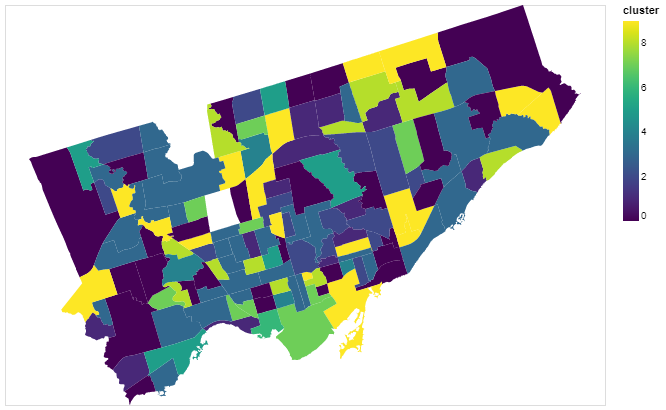

In [32]:
alt.Chart(merged).mark_geoshape(
).encode( 
    color='cluster', 
    tooltip=['cluster','ed_bin', 'income_bin', 'density_bin']
).properties( 
    width=600,
    height=400
)

#### Utilizing the Foursquare API to explore and segment neighborhoods

In [34]:
import requests

CLIENT_ID = os.environ['FOURSQUARE_CLIENT_ID']
CLIENT_SECRET = os.environ['FOURSQUARE_CLIENT_SECRET']
LIMIT = 100
VERSION = '20190404'

# ---------------------------------------------
# The following function retrieves the venues given the names and coordinates and stores it into dataframe.
def getNearbyVenues(LIMIT, names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Retrieve all venues given the location

The location is defined as the nighbourhood name and the coordinates that were found for the Toronto postal codes (lab 2 this week).

The Foursquare API call needs the neighbourhood name and coordinates. Since in our data we have several neighbourhoods on the same row, we need to split them into individual ones.

In [35]:
neighbourhoods = pd.read_csv('./data/toronto_neighborhoods.csv', sep=';')
neighbourhoods.head()

,Postcode,Borough,Neighbourhood,latlng,Latitude,Longitude
0,M1B,Scarborough,"Rouge,Malvern",43.653963;-79.387207,43.653963,-79.387207
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.653963;-79.387207,43.653963,-79.387207
2,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.7678;-79.1866,43.767800,-79.186600
3,M1G,Scarborough,Woburn,43.7657168;-79.2218984,43.765717,-79.221898
4,M1H,Scarborough,Cedarbrae,43.7686;-79.2389,43.768600,-79.238900


In [36]:
def splitDataFrameList(df,target_column,separator):
    ''' df = dataframe to split,
    target_column = the column containing the values to split
    separator = the symbol used to perform the split
    returns: a dataframe with each entry for the target column separated, with each element moved into a new row. 
    The values in the other columns are duplicated across the newly divided rows.
    '''
    row_accumulator = []

    def splitListToRows(row, separator):
        split_row = row[target_column].split(separator)
        for s in split_row:
            new_row = row.to_dict()
            new_row[target_column] = s
            row_accumulator.append(new_row)

    df.apply(splitListToRows, axis=1, args = (separator, ))
    new_df = pd.DataFrame(row_accumulator)
    return new_df

In [37]:
neighbourhoods = splitDataFrameList(neighbourhoods, 'Neighbourhood', ',')
neighbourhoods.head()

,Borough,Latitude,Longitude,Neighbourhood,Postcode,latlng
0,Scarborough,43.653963,-79.387207,Rouge,M1B,43.653963;-79.387207
1,Scarborough,43.653963,-79.387207,Malvern,M1B,43.653963;-79.387207
2,Scarborough,43.653963,-79.387207,Highland Creek,M1C,43.653963;-79.387207
3,Scarborough,43.653963,-79.387207,Rouge Hill,M1C,43.653963;-79.387207
4,Scarborough,43.653963,-79.387207,Port Union,M1C,43.653963;-79.387207


In [39]:
toronto_neighborhoods = neighbourhoods[['Neighbourhood', 'Latitude', 'Longitude']]
toronto_venues = getNearbyVenues(LIMIT, names=toronto_neighborhoods['Neighbourhood'],
                                   latitudes=toronto_neighborhoods['Latitude'],
                                   longitudes=toronto_neighborhoods['Longitude']
                                  )

Rouge
Malvern
Highland Creek
Rouge Hill
Port Union
Guildwood
Morningside
West Hill
Woburn
Cedarbrae
Scarborough Village
East Birchmount Park
Ionview
Kennedy Park
Clairlea
Golden Mile
Oakridge
Cliffcrest
Cliffside
Scarborough Village West
Birch Cliff
Cliffside West
Dorset Park
Scarborough Town Centre
Wexford Heights
Maryvale
Wexford
Agincourt
Clarks Corners
Sullivan
Tam O'Shanter
Agincourt North
L'Amoreaux East
Milliken
Steeles East
L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview
Henry Farm
Oriole
Bayview Village
Silver Hills
York Mills
Newtonbrook
Willowdale
Willowdale South
York Mills West
Willowdale West
Parkwoods
Don Mills North
Flemingdon Park
Don Mills South
Bathurst Manor
Downsview North
Wilson Heights
Northwood Park
York University
CFB Toronto
Downsview East
Downsview West
Downsview Central
Downsview Northwest
Victoria Village
Woodbine Gardens
Parkview Hill
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto
The Danforth West
Riverdale
The Beaches West
Indi

In [40]:
print(toronto_venues.shape)
toronto_venues.head()

(5947, 7)


,Neighbourhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Rouge,43.653963,-79.387207,Downtown Toronto,43.653232,-79.385296,Neighborhood
1,Rouge,43.653963,-79.387207,Textile Museum of Canada,43.654396,-79.386500,Art Museum
2,Rouge,43.653963,-79.387207,Japango,43.655268,-79.385165,Sushi Restaurant
3,Rouge,43.653963,-79.387207,Sansotei Ramen 三草亭,43.655157,-79.386501,Ramen Restaurant
4,Rouge,43.653963,-79.387207,Cafe Plenty,43.654571,-79.389450,Café


In [41]:
toronto_venues.groupby('Neighbourhood').count().head(10)

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
Adelaide,100,100,100,100,100,100
Agincourt,5,5,5,5,5,5
Agincourt North,1,1,1,1,1,1
Albion Gardens,12,12,12,12,12,12
Alderwood,7,7,7,7,7,7
Bathurst Manor,20,20,20,20,20,20
Bathurst Quay,100,100,100,100,100,100
Bayview Village,3,3,3,3,3,3
Beaumond Heights,12,12,12,12,12,12


### How many unique categories are there?

In [42]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 281 uniques categories.


In [43]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighbourhood'] = toronto_venues['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Neighbourhood,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,American Restaurant,Antique Shop,Aquarium,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach Bar,Beer Bar,Beer Store,Belgian Restaurant,Bike Rental / Bike Share,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Buffet,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Housing Development,Ice Cream Shop,Indian Restaurant,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Leather Goods Store,Library,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Monument / Landmark,Movie Theater,Moving Target,Museum,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Other Repair Shop,Park,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Photography Studio,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tech Startup,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Udon Restaurant,University,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wine 

In [44]:
toronto_onehot.shape

(5947, 282)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category¶

In [46]:
toronto_grouped = toronto_onehot.groupby('Neighbourhood').mean().reset_index()
toronto_grouped.head()

,Neighbourhood,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,American Restaurant,Antique Shop,Aquarium,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach Bar,Beer Bar,Beer Store,Belgian Restaurant,Bike Rental / Bike Share,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Buffet,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Housing Development,Ice Cream Shop,Indian Restaurant,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Leather Goods Store,Library,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Monument / Landmark,Movie Theater,Moving Target,Museum,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Other Repair Shop,Park,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Photography Studio,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tech Startup,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Udon Restaurant,University,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wine 

##### What is the new size?

In [47]:
toronto_grouped.shape

(204, 282)

#### Get the top X most frequent venu type for each neighbourhood 

In [51]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [52]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighbourhood'] = toronto_grouped['Neighbourhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.shape

(204, 11)

In [53]:
neighborhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adelaide,Coffee Shop,Café,Hotel,Restaurant,Bar,Bakery,Steakhouse,Deli / Bodega,Burger Joint,Japanese Restaurant
1,Agincourt,Badminton Court,Chinese Restaurant,Shanghai Restaurant,Sandwich Place,Breakfast Spot,Convention Center,Cosmetics Shop,Field,Fast Food Restaurant,Farmers Market
2,Agincourt North,Pharmacy,Yoga Studio,Ethiopian Restaurant,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Event Space
3,Albion Gardens,Grocery Store,Pharmacy,Fried Chicken Joint,Fast Food Restaurant,Beer Store,Coffee Shop,Video Store,Sandwich Place,Liquor Store,Pizza Place
4,Alderwood,Pharmacy,Dance Studio,Pizza Place,Gym,Coffee Shop,Sandwich Place,Pub,Donut Shop,Dessert Shop,Diner


### Clustering based on Foursquare data

In [54]:
# set number of clusters
kclusters = 10

toronto_grouped_clustering = toronto_grouped.drop('Neighbourhood', 1)
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=1).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
print(kmeans.labels_[0:10])
print(len(kmeans.labels_))

[1 1 0 4 2 2 1 7 4 2]
204


In [58]:
toronto_neighborhoods.head()

,Neighbourhood,Latitude,Longitude
0,Rouge,43.653963,-79.387207
1,Malvern,43.653963,-79.387207
2,Highland Creek,43.653963,-79.387207
3,Rouge Hill,43.653963,-79.387207
4,Port Union,43.653963,-79.387207


In [69]:
toronto_merged = toronto_neighborhoods

# add clustering labels
toronto_merged['cluster'] = pd.Series(kmeans.labels_)

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood', how = 'inner')

toronto_merged.head() # check the last columns!

/home/jupyterlab/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,Neighbourhood,Latitude,Longitude,Cluster Labels,cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Rouge,43.653963,-79.387207,1.0,1.0,Coffee Shop,Japanese Restaurant,Café,Art Gallery,Breakfast Spot,Sushi Restaurant,Bubble Tea Shop,Bar,American Restaurant,Exhibit
1,Malvern,43.653963,-79.387207,1.0,1.0,Coffee Shop,Japanese Restaurant,Café,Art Gallery,Breakfast Spot,Sushi Restaurant,Bubble Tea Shop,Bar,American Restaurant,Exhibit
2,Highland Creek,43.653963,-79.387207,0.0,0.0,Coffee Shop,Japanese Restaurant,Café,Art Gallery,Breakfast Spot,Sushi Restaurant,Bubble Tea Shop,Bar,American Restaurant,Exhibit
3,Rouge Hill,43.653963,-79.387207,4.0,4.0,Coffee Shop,Japanese Restaurant,Café,Art Gallery,Breakfast Spot,Sushi Restaurant,Bubble Tea Shop,Bar,American Restaurant,Exhibit
4,Port Union,43.653963,-79.387207,2.0,2.0,Coffee Shop,Japanese Restaurant,Café,Art Gallery,Breakfast Spot,Sushi Restaurant,Bubble Tea Shop,Bar,American Restaurant,Exhibit


In [74]:
sorted(toronto_merged.Neighbourhood.tolist())

['Adelaide',
 'Agincourt',
 'Agincourt North',
 'Albion Gardens',
 'Alderwood',
 'Bathurst Manor',
 'Bathurst Quay',
 'Bayview Village',
 'Beaumond Heights',
 'Bedford Park',
 'Berczy Park',
 'Birch Cliff',
 'Bloordale Gardens',
 'Brockton',
 'Business Reply Mail Processing Centre 969 Eastern',
 'CFB Toronto',
 'CN Tower',
 'Cabbagetown',
 'Caledonia-Fairbanks',
 'Canada Post Gateway Processing Centre',
 'Cedarbrae',
 'Central Bay Street',
 'Chinatown',
 'Christie',
 'Church and Wellesley',
 'Clairlea',
 'Clarks Corners',
 'Cliffcrest',
 'Cliffside',
 'Cliffside West',
 'Cloverdale',
 'Commerce Court',
 'Davisville',
 'Davisville North',
 'Deer Park',
 'Del Ray',
 'Design Exchange',
 'Don Mills North',
 'Don Mills South',
 'Dorset Park',
 'Dovercourt Village',
 'Downsview',
 'Downsview Central',
 'Downsview East',
 'Downsview North',
 'Downsview Northwest',
 'Downsview West',
 'Dufferin',
 'East Birchmount Park',
 'East Toronto',
 'Emery',
 'Eringate',
 'Exhibition Place',
 'Fairview',

In [65]:
toronto_merged.rename(columns = {'Neighbourhood': 'neighbourhood'}, inplace = True)
merged_foursquare = shape_df.merge(toronto_merged, on = 'neighbourhood', how='inner')
merged_foursquare.set_index('neighbourhood', inplace=True)

In [68]:
merged.shape

(140, 7)

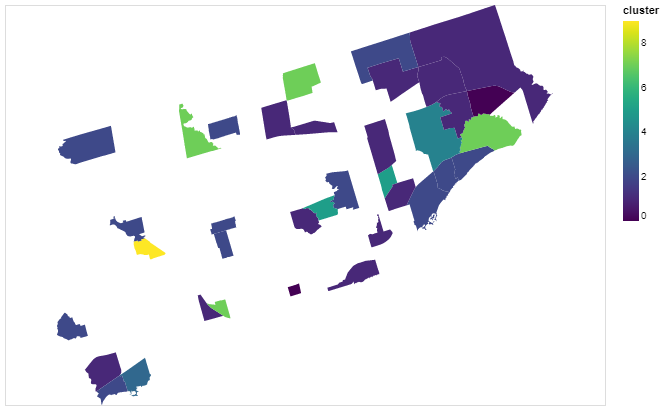

In [66]:
alt.Chart(merged_foursquare).mark_geoshape(
).encode( 
    color='cluster', 
    tooltip=['cluster', '1st Most Common Venue', '2nd Most Common Venue', '3rd Most Common Venue']
).properties( 
    width=600,
    height=400
)

In [78]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors


# create map
map_clusters = folium.Map(location=[79.3832, 43.6532], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighbourhood'],kmeans.labels_):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters


### Conclusion:
    - There is more work to be done for aligning the Neibourhood names obtained from the Foursquare API and the official ones
    - After this is achieved it would be interesting to see how the clusters change when including also the demography information
    - Using other clustering methods would also be interesting
    